<a href="https://colab.research.google.com/github/Keauranthain/Projet_Larry_Le_Malicieux/blob/main/ML_Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.**Dataset Overview**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<ipython-input-3-b65adad20aeb>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selected = samples_df.groupby("label").apply(


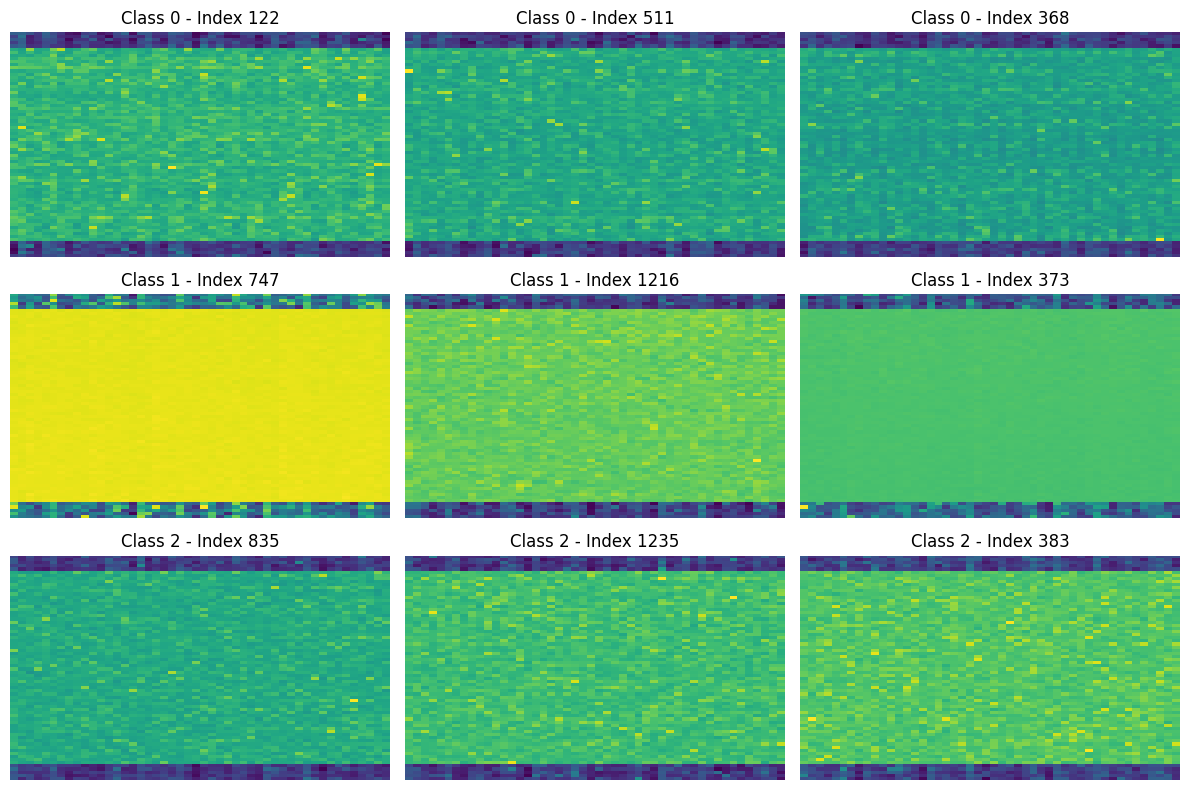

In [3]:
train_csv_path = "/content/drive/MyDrive/BRNO/MPA-MLF_DATA_NEW/CSV_data/data/train_processed.csv"
labels_df = pd.read_csv(train_csv_path)

X = labels_df.drop(columns=["ID", "target"]).values
y = labels_df["target"].values

X_reshaped = X.reshape((-1, 72, 48))

samples_df = pd.DataFrame({"index": np.arange(len(y)), "label": y})

n_samples_per_class = 3
selected = samples_df.groupby("label").apply(
    lambda x: x.sample(n=n_samples_per_class, random_state=42)
).reset_index(drop=True)
fig, axes = plt.subplots(nrows=3, ncols=n_samples_per_class, figsize=(12, 8))

for i, row in selected.iterrows():
    img = X_reshaped[int(row["index"])]
    row_idx = int(row["label"])
    col_idx = i % n_samples_per_class
    ax = axes[row_idx, col_idx]
    ax.imshow(img, aspect='auto', cmap='viridis')
    ax.set_title(f"Class {row['label']} - Index {row['index']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 2.**PCA**

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

2.1. PCA

In [5]:
X_train = labels_df.drop(columns=["ID", "target"]).values  # shape (N, 3456)
y_train = labels_df["target"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

2.2. Plot

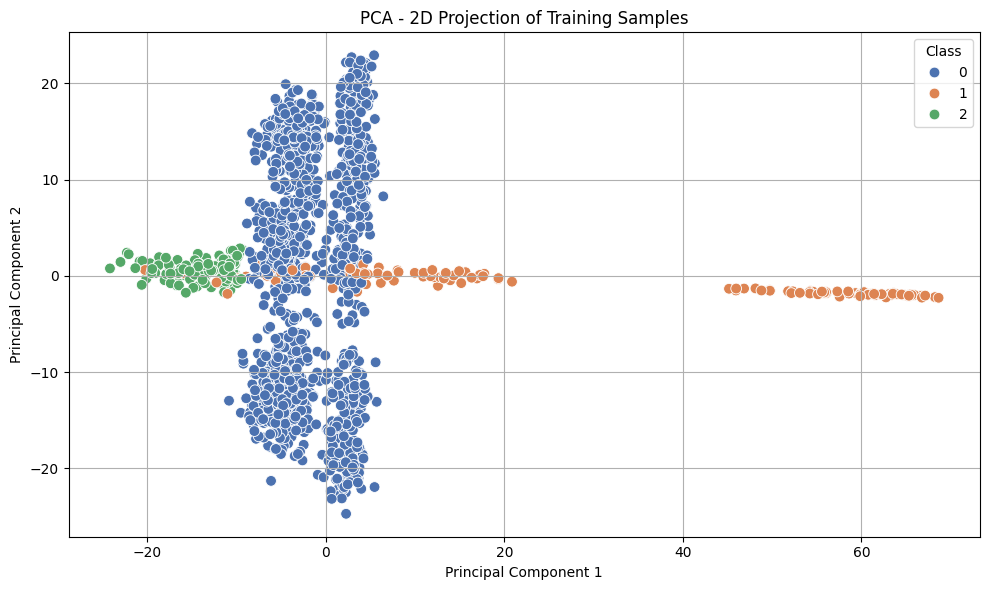

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='deep', s=60)
plt.title("PCA - 2D Projection of Training Samples")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3.**T-SNE**

In [7]:
from sklearn.manifold import TSNE

3.1. T-SNE

In [8]:
n_samples = 1000
X_subset = X[:n_samples]
y_subset = y[:n_samples]

scaler = StandardScaler()
X_scaled_tsne = scaler.fit_transform(X_subset)

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_scaled_tsne)

3.2. Plot

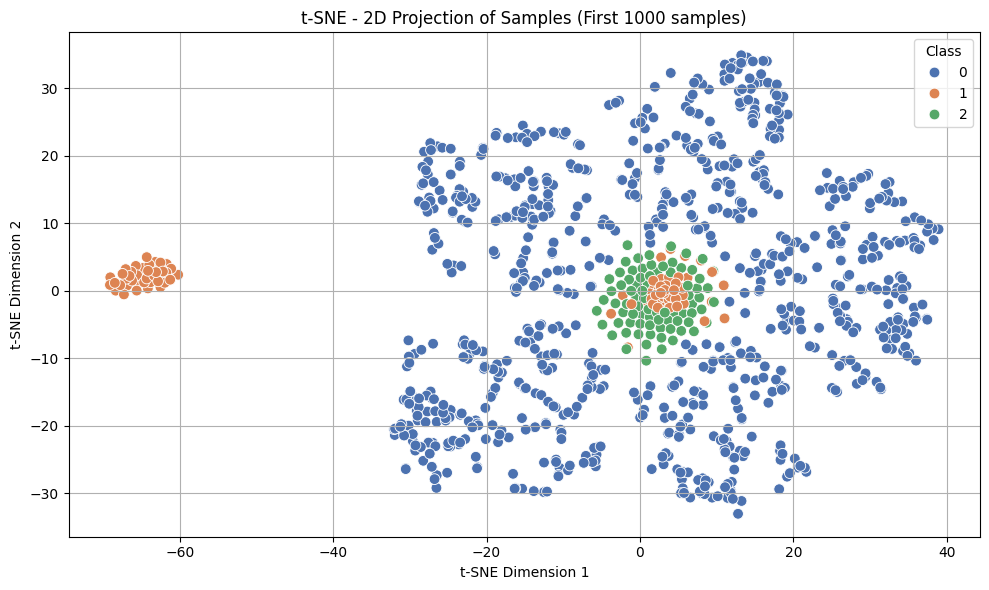

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_subset, palette='deep', s=60)
plt.title(f"t-SNE - 2D Projection of Samples (First {n_samples} samples)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()


# 4.**Data Preprocessing**

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

In [11]:
X = labels_df.drop(columns=["ID", "target"]).values  # (N, 3456)
y = labels_df["target"].values

X = X.reshape((-1, 72, 48))

X = (X - X.min()) / (X.max() - X.min())

X = X[..., np.newaxis]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape :", X_train.shape)
print("X_val shape   :", X_val.shape)
print("y_train dist  :", np.bincount(y_train))
print("y_val dist    :", np.bincount(y_val))



X_train shape : (1192, 72, 48, 1)
X_val shape   : (299, 72, 48, 1)
y_train dist  : [966 113 113]
y_val dist    : [243  28  28]


# 5.**Model**

In [12]:
import keras.src as tf
from keras.src.models import Sequential
from keras.src.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.src.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

5.1. Configuration

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(72, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5.2. Compilation

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

5.3. Training

In [15]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=15,
    batch_size=32
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.8006 - loss: 0.7412 - val_accuracy: 0.8127 - val_loss: 0.7466
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.8122 - loss: 0.6321 - val_accuracy: 0.8127 - val_loss: 0.5794
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.8039 - loss: 0.6670 - val_accuracy: 0.8127 - val_loss: 0.6145
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8146 - loss: 0.5910 - val_accuracy: 0.8127 - val_loss: 0.5692
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.8142 - loss: 0.5971 - val_accuracy: 0.8127 - val_loss: 0.5635
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8100 - loss: 0.5306 - val_accuracy: 0.8127 - val_loss: 0.4319
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8032 - loss: 0.4709 - val_accuracy: 0.8863 - val_loss: 0.2876
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.8613 - loss: 0.2912 - val_accuracy: 0.

5.4. Plot

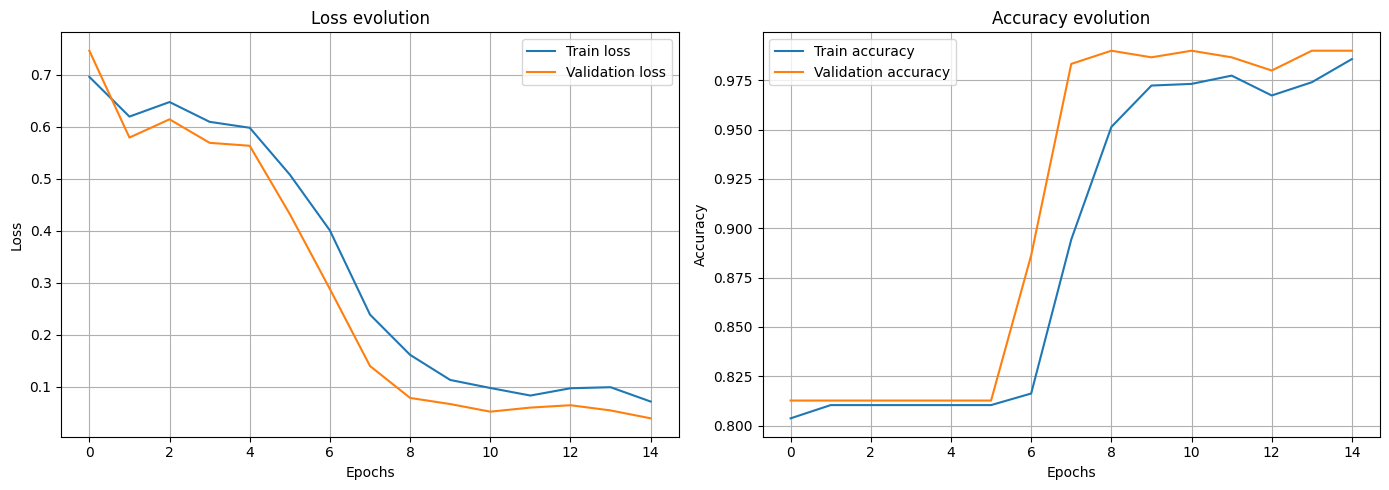

In [16]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


5.5. Confusion matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


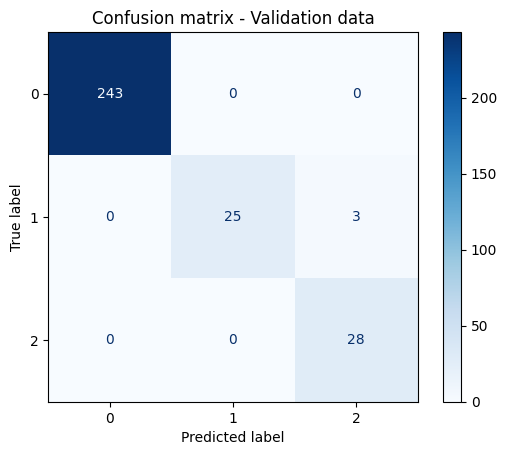

In [17]:
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)  # classes prédites

cm = confusion_matrix(y_val, y_val_pred)
labels = [0, 1, 2]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion matrix - Validation data")
plt.grid(False)
plt.show()


# 6.**Submission file**

In [18]:
test_csv_path = "/content/drive/MyDrive/BRNO/MPA-MLF_DATA_NEW/CSV_data/data/test_processed.csv"

df_test = pd.read_csv(test_csv_path)

df_test_sorted = df_test.sort_values(by="ID").reset_index(drop=True)

test_ids = df_test_sorted["ID"].values

X_test = df_test_sorted.drop(columns=["ID"]).values
X_test = X_test.reshape((-1, 72, 48, 1))

X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

y_test_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_probs, axis=1)

df_submission = pd.DataFrame({
    "ID": test_ids,
    "target": y_test_pred
})

submission_path = "submission.csv"
df_submission.to_csv(submission_path, index=False)

print(f"✅ Submission file ready : {submission_path} ")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
✅ Submission file ready : submission.csv 
